In [1]:
import sys
# setup python path to be able to import packages ans use them
sys.path.append('../codes/notears/')
sys.path.append('../codes/')

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import notears
import numpy as np
import pandas as pd
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils import plot_graph
from networkx.drawing.nx_agraph import graphviz_layout
from notears.linear import notears_linear

## Load the data

In [4]:
data = pd.read_csv("../data/skcm_vaf.csv").drop(['Unnamed: 0', 'Tumor_Sample_Barcode'], axis=1)
data.fillna(0, inplace=True)
data.head()

,ARID2,BRAF,BRD7,CDK4,CDKN2A,COL5A1,CTNNB1,DACH1,DDX3X,GNA11,...,MAP2K1,MECOM,NF1,NRAS,PPP6C,PTEN,RAC1,RB1,RQCD1,TP53
0,0.000000,0.472727,0.0,0.0,0.0,0.000000,0.0,0.0,0.9,0.0,...,0.0,0.000000,0.000000,0.804444,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.272727,0.357143,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.258824,0.000000,0.256881,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.0,0.277778,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.388889,0.0,0.000000,0.0,0.0,0.0,0.333333
3,0.827160,0.941176,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.754386,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.911111,0.440559,0.0,0.000000,0.0,0.0,0.0,0.000000


## Filter out passenger genes

In [5]:
driver = 'BRAF NRAS TP53 CDKN2A PTEN IDH1 MAP2K1 NF1 ARID2 RAC1 CTNNB1 CDK4 PPP6C KIT DDX3X RB1 GNA11 KRAS HRAS'.split()
data = data[driver]

## Parameters

In [6]:
n_bootstrap = 100
lambda1 = 0.002
alpha = 0.05
pos_threshold = 0.09
neg_threshold = -0.01

## Bootstrap

In [7]:

Ws = []
for i in tqdm(range(n_bootstrap)):
    np.random.seed(42 + i)
    bootstrap_indices = np.random.choice(data.index, size=data.shape[0], replace=True)
    bootstrap_data = data.loc[bootstrap_indices]
    W = notears_linear(bootstrap_data.values, lambda1=lambda1, loss_type='l2', w_threshold=0.0, max_iter=300)
    Ws.append(W.T)
Ws = np.array(Ws)

100%|██████████| 100/100 [01:00<00:00,  1.41it/s]


## Remove non-significant edges

/home/msadegh/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/msadegh/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


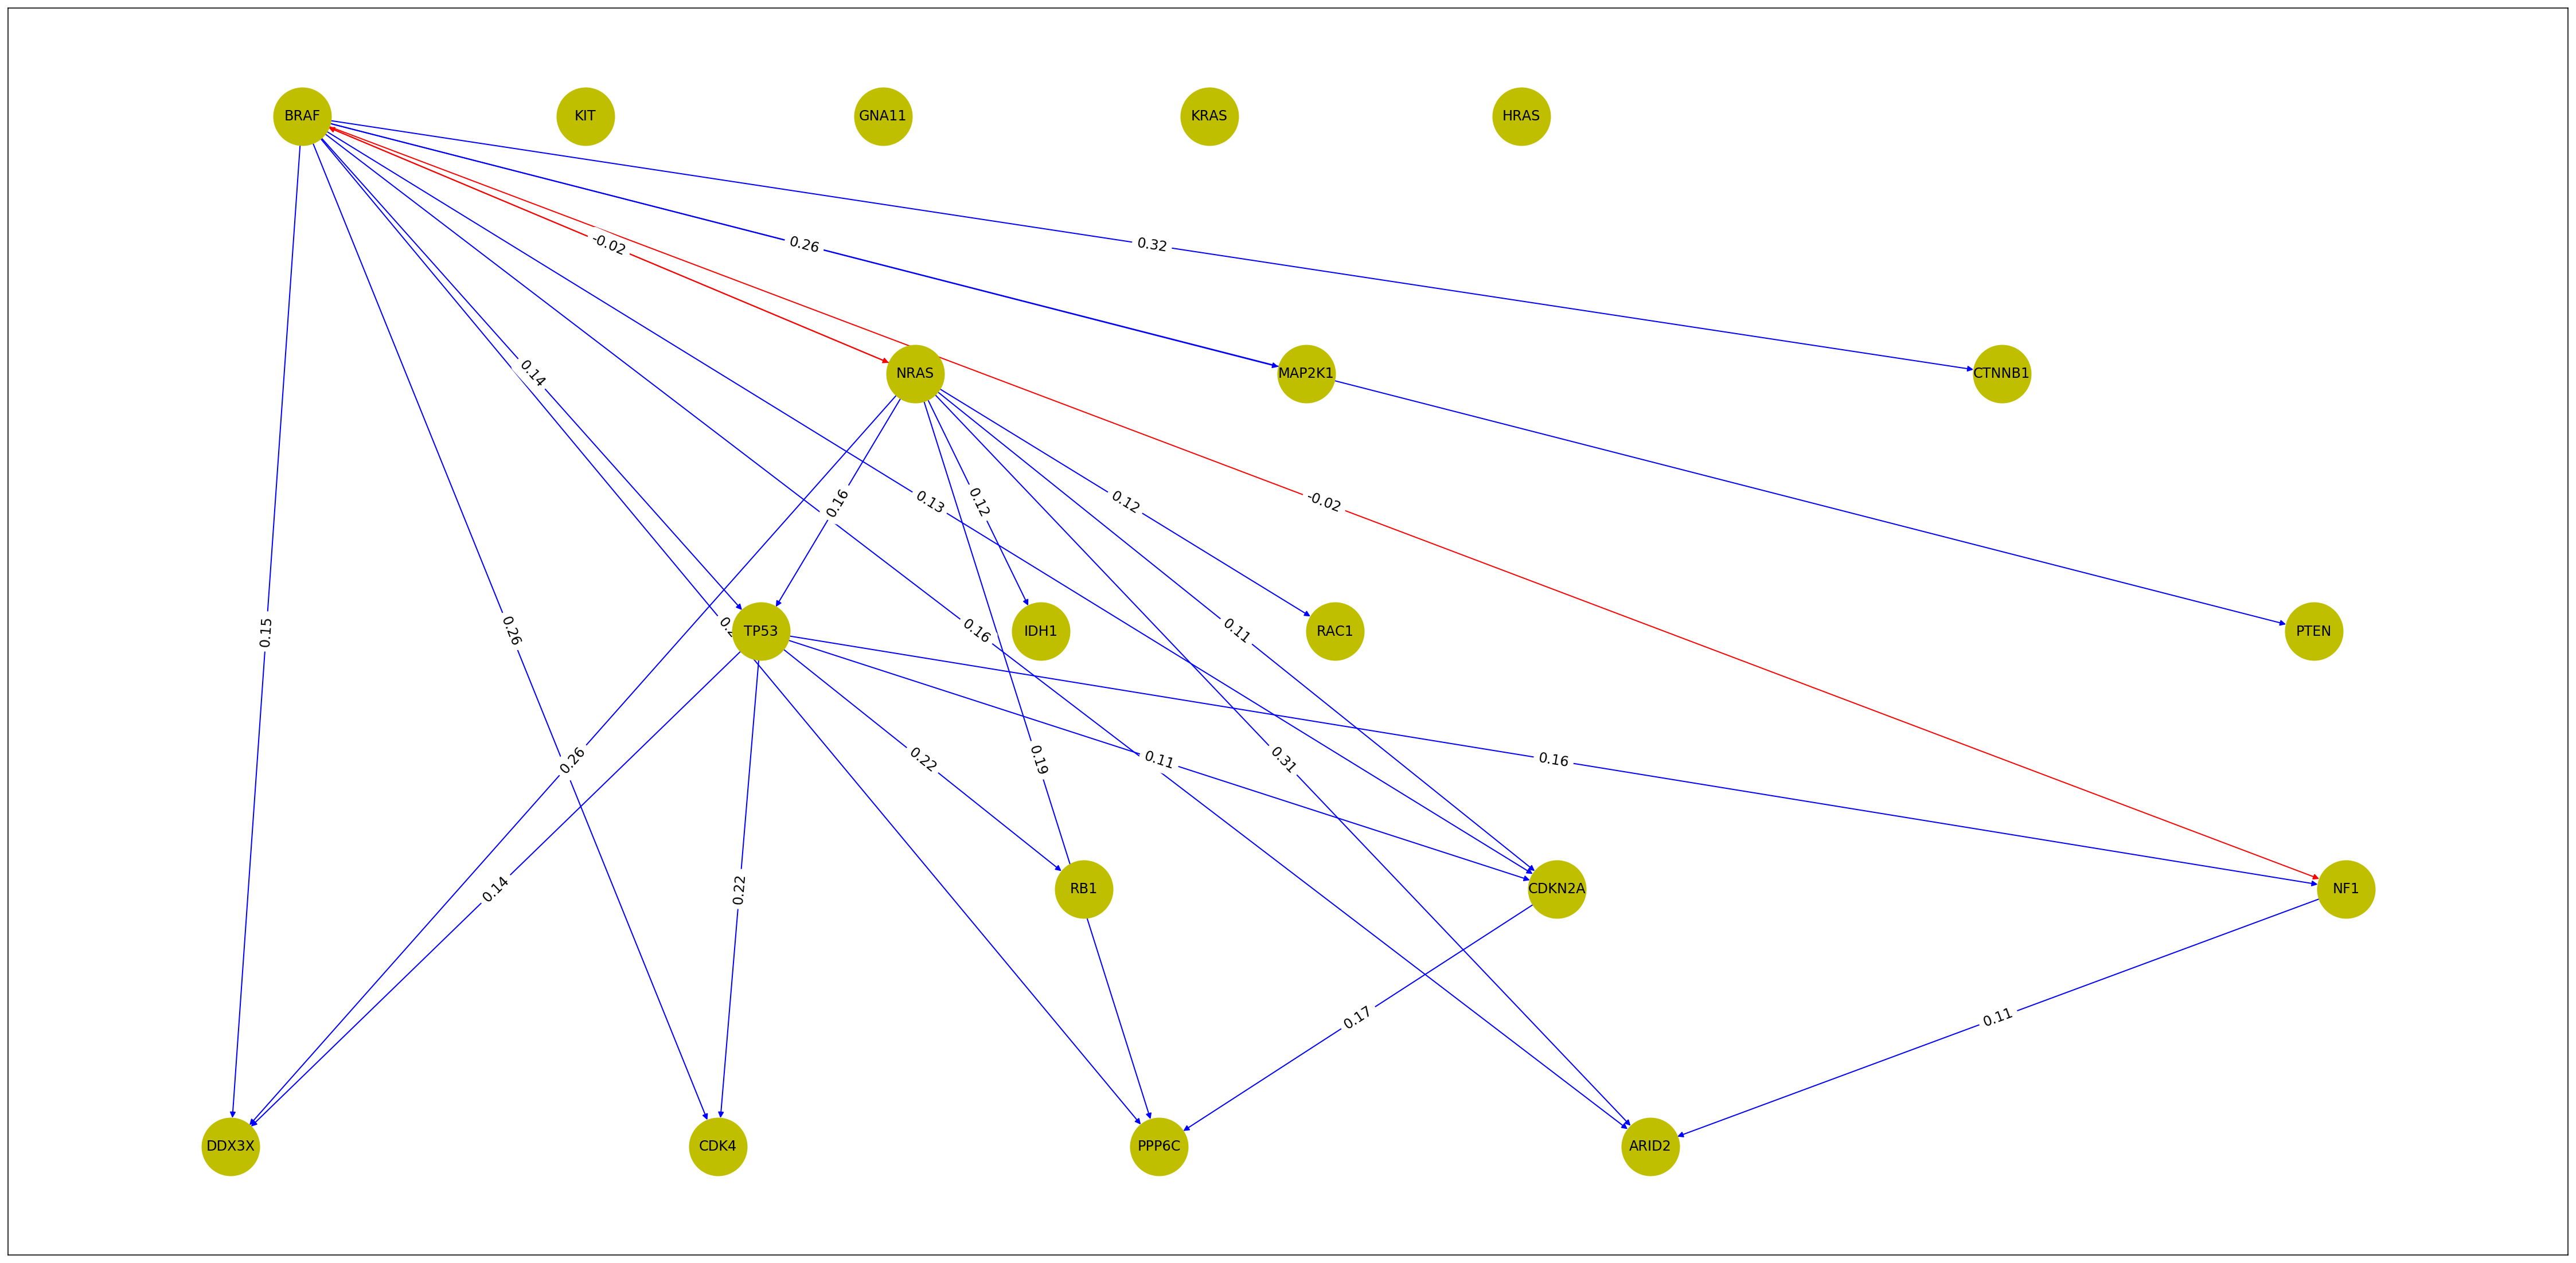

In [8]:

t_pos, p_pos = stats.ttest_1samp(Ws, pos_threshold, axis=0)
t_pos = pd.DataFrame(t_pos, columns=data.columns, index=data.columns)
p_pos = pd.DataFrame(p_pos, columns=data.columns, index=data.columns)

t_neg, p_neg = stats.ttest_1samp(Ws, neg_threshold, axis=0)
t_neg = pd.DataFrame(t_neg, columns=data.columns, index=data.columns)
p_neg = pd.DataFrame(p_neg, columns=data.columns, index=data.columns)

W = Ws.mean(axis=0)
W_pos = ((t_pos > 0) & (p_pos < alpha)) * W
W_neg = ((t_neg < 0) & (p_neg < alpha)) * W
W = W_pos + W_neg
G1 = nx.from_pandas_adjacency(W[W > 0].fillna(0), create_using=nx.DiGraph)
G2 = nx.from_pandas_adjacency(W[W < 0].fillna(0), create_using=nx.DiGraph)
plot_graph(G1, G2)


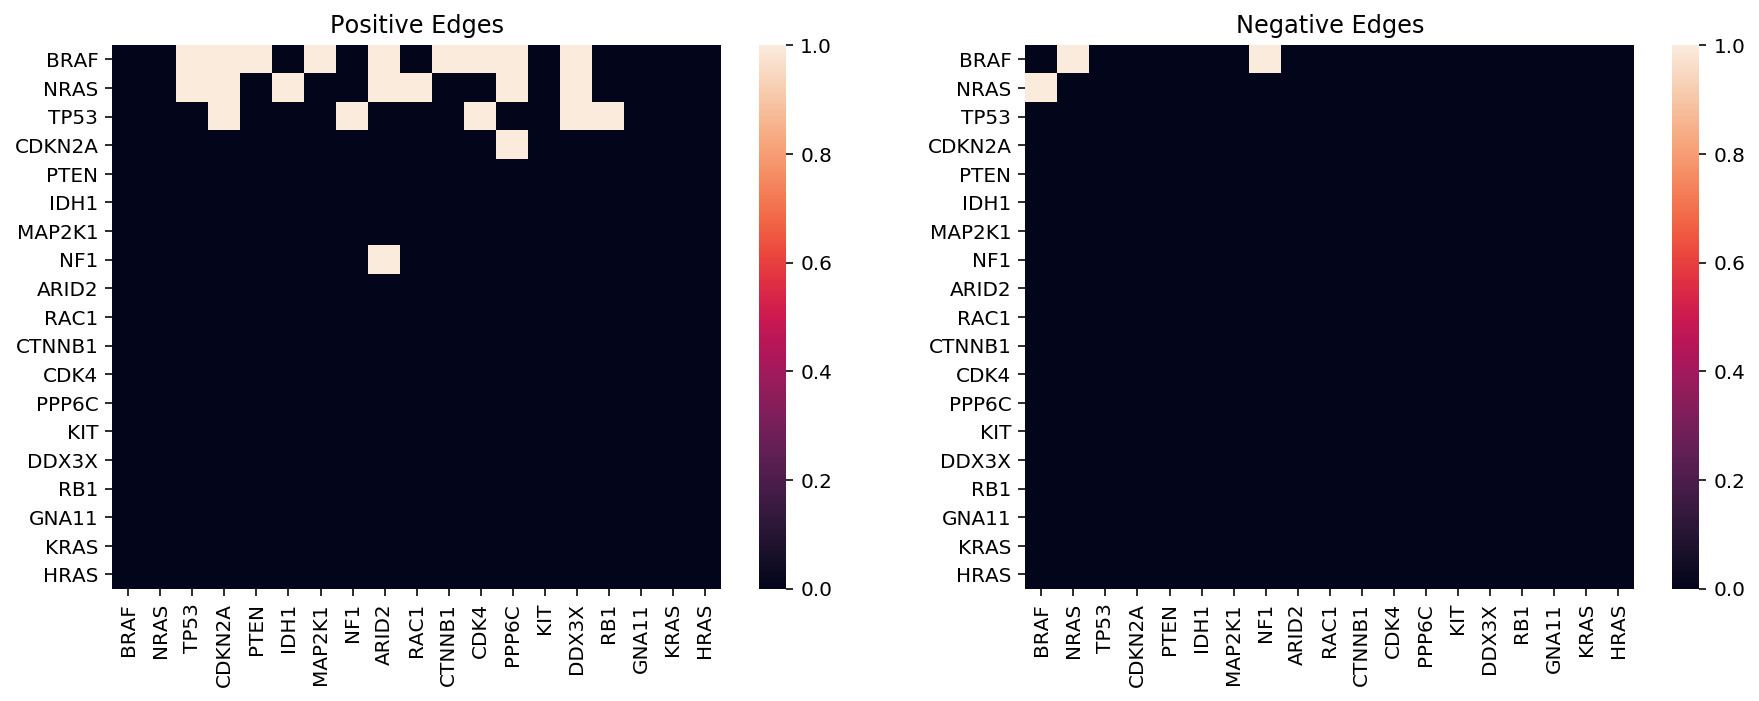

In [9]:
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1);
sns.heatmap(W_pos != 0);
plt.title('Positive Edges');
plt.subplot(1, 2, 2);
sns.heatmap(W_neg != 0);
plt.title('Negative Edges');

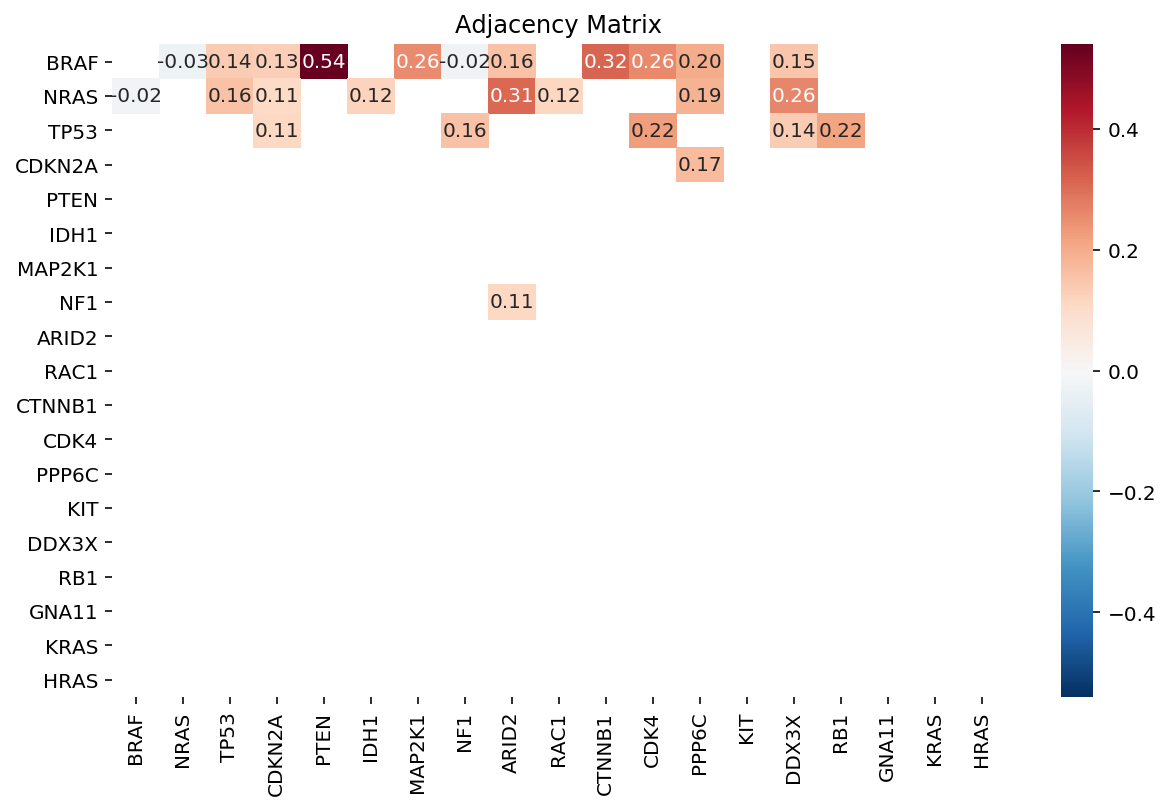

In [10]:
plt.figure(figsize=(10, 6));
sns.heatmap(W, cmap='RdBu_r', vmin=-np.max([W.max(), W.min()]), vmax=np.max([W.max(), W.min()]), annot=True, fmt='.2f', mask=np.isclose(W, 0));
plt.title('Adjacency Matrix');